In [1]:
#Load libraries to the model
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
!pip install pmdarima
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

In [2]:
#load dataset
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('C:/Users/Sree Lakshmi/Desktop/data.txt',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

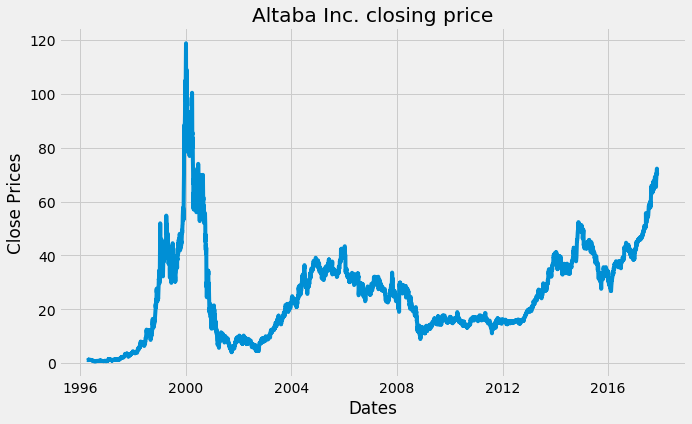

In [3]:
#Visualizing closing price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close'])
plt.title('Altaba Inc. closing price')
plt.show()

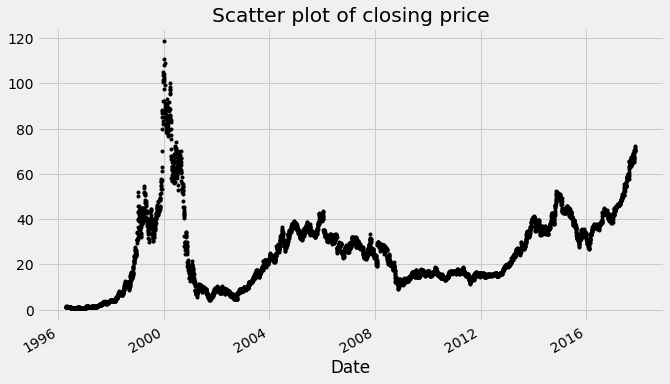

In [4]:
#Scatterplot
df_close = data['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

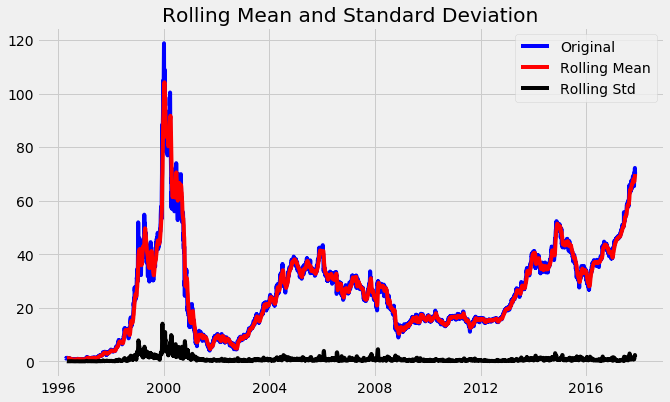

Results of dickey fuller test
Test Statistics                  -2.062280
p-value                           0.259950
No. of lags used                 32.000000
Number of observations used    5401.000000
critical value (1%)              -3.431561
critical value (5%)              -2.862075
critical value (10%)             -2.567055
dtype: float64


In [5]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

<Figure size 720x432 with 0 Axes>

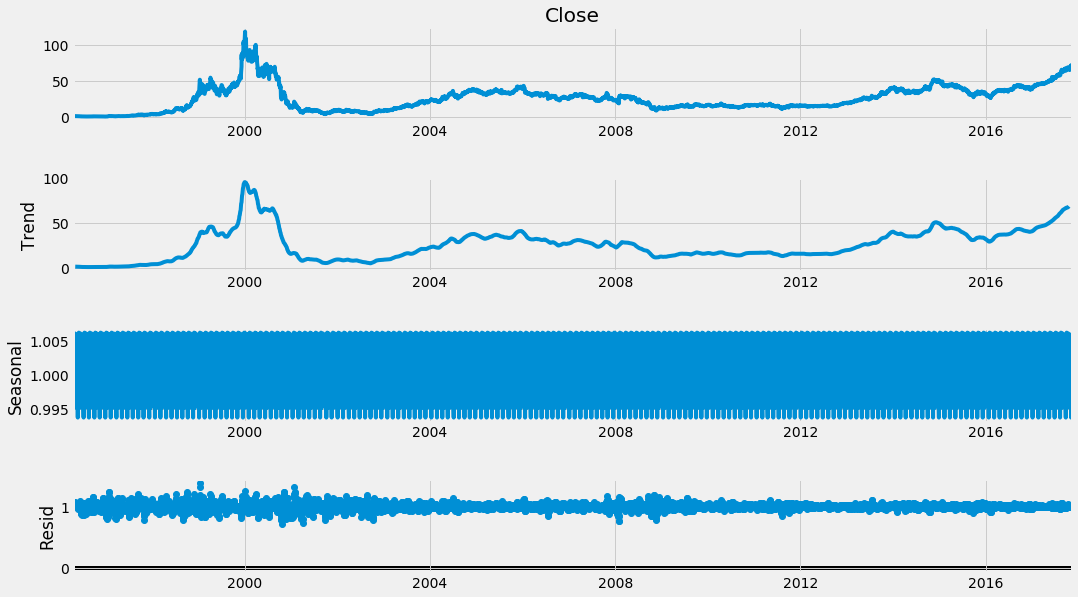

In [6]:
#sepration of trend & seasonality
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


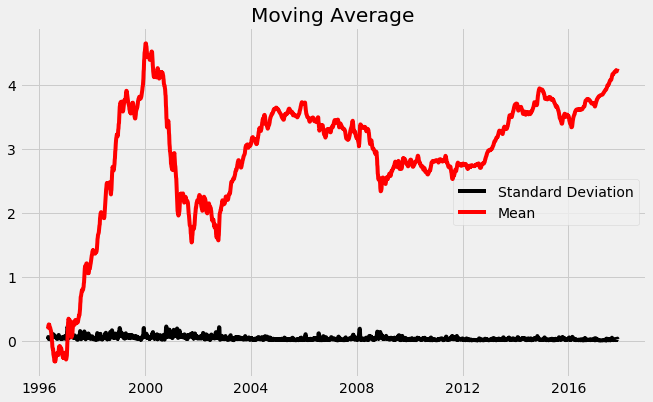

In [7]:
#moving average
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

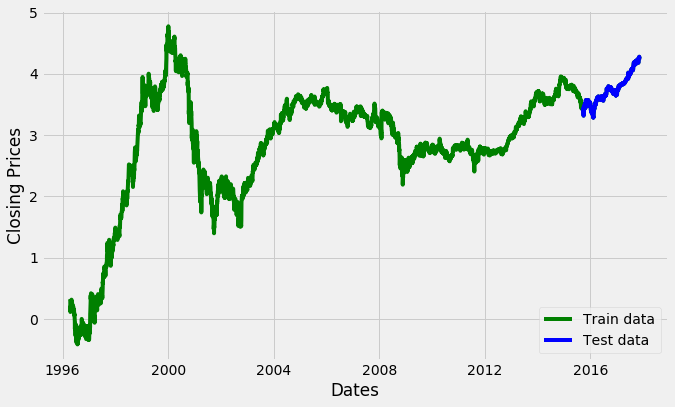

In [8]:
#split the data into train & Test data
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [9]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-18377.184, BIC=-18364.196, Time=3.799 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-18375.274, BIC=-18355.791, Time=2.003 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-18375.280, BIC=-18355.798, Time=4.583 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-18377.513, BIC=-18371.019, Time=1.455 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-18378.090, BIC=-18352.114, Time=4.588 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=-18386.172, BIC=-18353.702, Time=5.205 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=-18386.124, BIC=-18360.147, Time=2.282 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=-18384.395, BIC=-18345.431, Time=6.456 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=-18384.593, BIC=-18345.628, Time=7.482 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=-18386.043, BIC=-18353.573, Time=11.672 sec

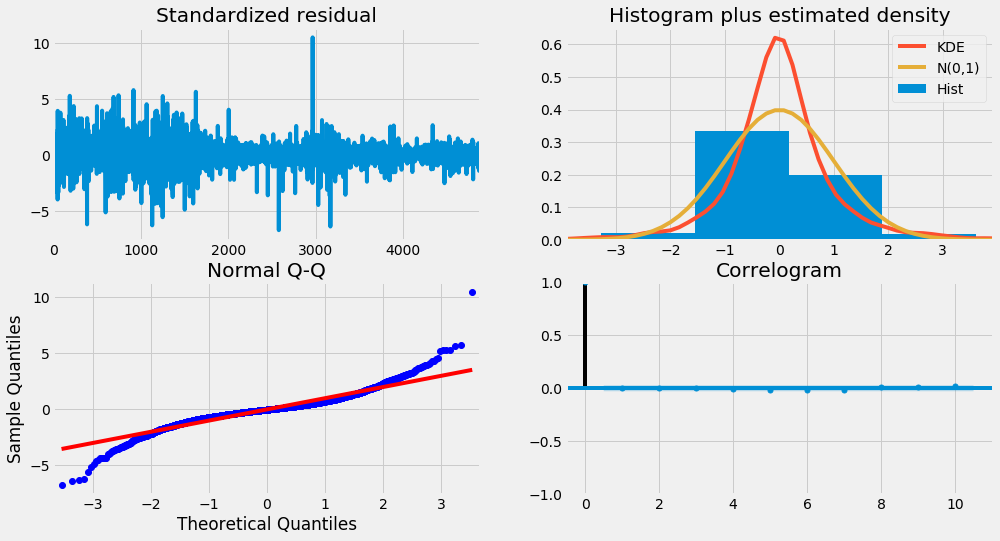

In [10]:
#Residual plots
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [11]:
#Creating ARIMA with the provided parameters p,d,q
model = ARIMA(train_data, order=(3, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())


C:\Users\Sree Lakshmi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Sree Lakshmi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4886
Model:                 ARIMA(3, 1, 2)   Log Likelihood                9204.201
Method:                       css-mle   S.D. of innovations              0.037
Date:                Tue, 14 Jul 2020   AIC                         -18394.402
Time:                        10:56:02   BIC                         -18348.943
Sample:                             1   HQIC                        -18378.450
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.001      1.292      0.196      -0.000       0.002
ar.L1.D.Close    -1.6322      0.017    -96.727      0.000      -1.665      -1.599
ar.L2.D.Close    -0.9840      0.025    -

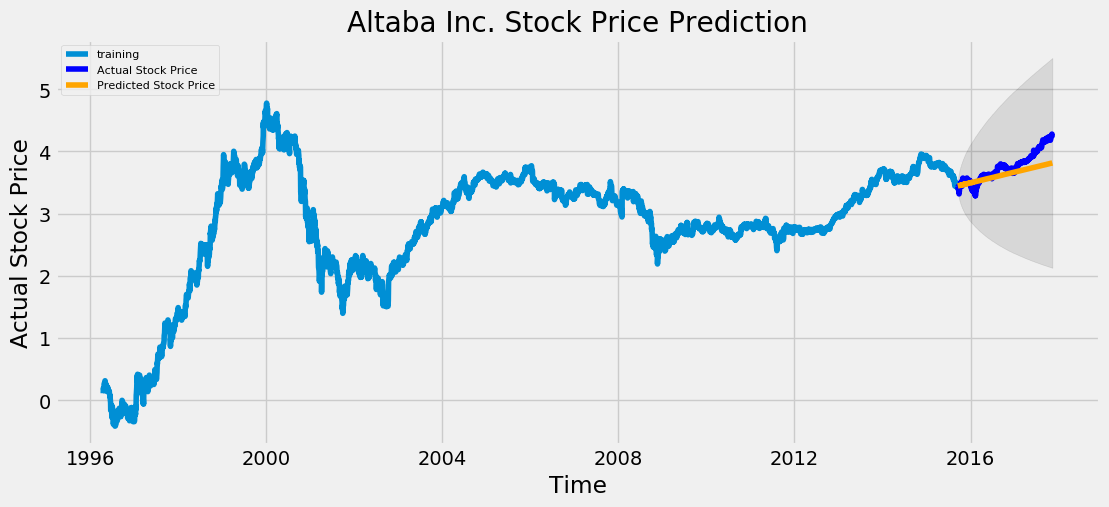

In [12]:
# Forecast the stock price keeping 95% confidence 
fc, se, conf = fitted.forecast(544, alpha=0.05)  
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Altaba Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [13]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.033313876108351875
MAE: 0.13802356777945157
RMSE: 0.18252089225168683
MAPE: 0.03533168796606593
